# Load Library

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack, get_LOMIA_results, imputation_attack
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from experiment_utils import MIAExperiment
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds, get_mutual_info_btn_sens_and_out_per_subgroup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
import copy
from scipy.stats import kendalltau, spearmanr

import matplotlib as mpl

# Load Dataset

In [4]:
experiment = MIAExperiment(name='Adult')

# Train/Load Model

In [5]:
save_model = True

print(f"Training classifier for experiment: {experiment}")
try:
    experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')
    print(f"Loaded classifier for experiment from file: {experiment}")
except:
    # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
    experiment.clf = model_utils.get_model(max_iter=500)
    experiment.clf.fit(experiment.X_train, experiment.y_tr_onehot)

    if save_model:
        model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Adult
Loaded classifier for experiment from file: Adult


# Launch Attribute Inference Attacks

In [7]:
experiment.sens_pred, case_indices = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)

# Launch Imputation Attacks using Auxiliary Datasets with Varying Size and Marginal Prior

In [8]:
imputation_aux_dict = {}
X_aux = experiment.X_test.copy()
y_aux = experiment.y_te
married_indices = X_aux[X_aux['marital_Married']==True].index
single_indices = X_aux[X_aux['marital_Married']==False].index

tc_vals = [100, 500, 1000, 2500, 5000]
pcnt_vals = [0.1, 0.2, 0.3, 0.4, 0.5]
for tc in tc_vals:
    for pcnt_s in pcnt_vals:
        pcnt_single = pcnt_s
        total_count = tc
        married_sample_indices = X_aux.loc[married_indices].sample(n=total_count-int(total_count * pcnt_single), replace=False, random_state=42).index
        single_sample_indices = X_aux.loc[single_indices].sample(n=int(total_count * pcnt_single), replace=False, random_state=42).index

        all_sample_indices = married_sample_indices.append(single_sample_indices)
        imputation_aux_dict[(tc, pcnt_s)] = X_aux.loc[all_sample_indices].copy(), y_aux[all_sample_indices]

In [9]:
imputation_perf_dict = {}
for tc in tc_vals:
    imputation_perf_dict[tc] = {}
    for pcnt_s in pcnt_vals:
        X_aux, y_aux = imputation_aux_dict[(tc, pcnt_s)]
        imputation_pred = imputation_attack(experiment, experiment.X_train, experiment.y_tr, X_aux, y_aux, experiment.ds.ds.meta)
        imputation_perf_dict[tc][pcnt_s] = round(100 * accuracy_score(experiment.sens_val_ground_truth, imputation_pred), 2)

# Plot Results

In [11]:
print(f'CSMIA Accuracy: {round(100 * accuracy_score(experiment.sens_val_ground_truth, experiment.sens_pred), 2)}')
print(f'LOMIA Accuracy: {round(100 * accuracy_score(experiment.sens_val_ground_truth, experiment.sens_pred_LOMIA), 2)}')

CSMIA Accuracy: 69.96
LOMIA Accuracy: 70.16


In [12]:
print(pd.DataFrame.from_dict(imputation_perf_dict, orient='index').T[[100, 500, 1000, 5000]].round(2).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
 & 100 & 500 & 1000 & 5000 \\
\midrule
0.100000 & 47.96 & 48.99 & 58.18 & 57.50 \\
0.200000 & 55.41 & 68.56 & 68.52 & 68.96 \\
0.300000 & 64.53 & 71.44 & 71.32 & 71.77 \\
0.400000 & 70.55 & 72.61 & 73.02 & 72.99 \\
0.500000 & 70.81 & 73.12 & 73.27 & 73.74 \\
\bottomrule
\end{tabular}



# Launch ImpI (Ideal Imputation Attack) and ImpP (Practical Imputation Attack)

In [13]:
original_test_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train']==1].copy().reset_index(drop=True).drop(['is_train'], axis=1)
n = (np.array(original_test_df['occupation'].value_counts().tolist()) * 500 / 35222).astype(int)
n[[1, 4, 5, 6, 8]] = [0, 0, 0, 0, 0]
p = (np.ones_like(n) * -0.441171595477939).tolist()
random_state = 42
indices = experiment.ds.ds.sample_indices_matching_correlation(experiment.X_train, experiment.y_tr, p=p, n=n, subgroup_col_name='occupation', random_state=experiment.random_state)

random_indices = experiment.X_train.sample(n=500, replace=False, random_state=random_state).index
X_aux_ideal, y_aux_ideal = experiment.X_train.loc[random_indices].copy().reset_index(drop=True), experiment.y_tr[random_indices]
X_aux_practical, y_aux_practical = experiment.X_train.loc[indices].copy().reset_index(drop=True), experiment.y_tr[indices]

100%|██████████| 14/14 [00:00<00:00, 35.23it/s]


In [17]:
subgroup_col = 'occupation'
subgroup_vals = experiment.ds.ds.original_df[subgroup_col].unique()

conditions = [{subgroup_col: i} for i in subgroup_vals] + [{}]
for condition in conditions:
    fcondition = f'{condition}'
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, X_aux_practical, y_aux_practical, condition)
    if condition == {}:
        print(f'Correlation between sensitive attribute and output for subgroup occupation=All: {correlation}')
    else:
        print(f'Correlation between sensitive attribute and output for subgroup occupation={condition[subgroup_col]}: {correlation}')

Correlation between sensitive attribute and output for subgroup occupation=Prof-specialty: -0.3779644730092272
Correlation between sensitive attribute and output for subgroup occupation=Other-service: -0.49999999999999994
Correlation between sensitive attribute and output for subgroup occupation=Adm-clerical: -0.4244373438135821
Correlation between sensitive attribute and output for subgroup occupation=Craft-repair: -0.4244373438135821
Correlation between sensitive attribute and output for subgroup occupation=Farming-fishing: nan
Correlation between sensitive attribute and output for subgroup occupation=Machine-op-inspct: nan
Correlation between sensitive attribute and output for subgroup occupation=Exec-managerial: -0.4335742748772952
Correlation between sensitive attribute and output for subgroup occupation=Priv-house-serv: nan
Correlation between sensitive attribute and output for subgroup occupation=Sales: -0.40824829046386324
Correlation between sensitive attribute and output for 

In [23]:
imputation_pred = imputation_attack(experiment, experiment.X_train, experiment.y_tr, X_aux_practical, y_aux_practical, experiment.ds.ds.meta)
imputation_pred_ideal = imputation_attack(experiment, experiment.X_train, experiment.y_tr, X_aux_ideal, y_aux_ideal, experiment.ds.ds.meta)

perf_dict = {}
subgroup_col_name = 'occupation'
subgroup_vals = experiment.ds.ds.original_df[subgroup_col_name].unique()

conditions = [{subgroup_col_name: i} for i in subgroup_vals]
for i, condition in enumerate(conditions):
    # condition = {subgroup_col_name: i}
    fcondition = f'{condition}'
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)
    correlation_prediction = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.sens_pred, condition)
    perf_dict[fcondition] = {}
    perf_dict[fcondition]['subgroup_val'] = subgroup_vals[i]
    perf_dict[fcondition]['correlation'] = correlation
    perf_dict[fcondition]['correlation_diff'] = np.abs(correlation + 0.441171595477939)
    indices = get_indices_by_group_condition(experiment.X_train, condition)
    perf_dict[fcondition]['CSMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred[indices]).sum()/len(indices)
    perf_dict[fcondition]['LOMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred_LOMIA[indices]).sum()/len(indices)
    perf_dict[fcondition]['imputation_accuracy'] = (experiment.sens_val_ground_truth[indices] == imputation_pred[indices]).sum()/len(indices)
    perf_dict[fcondition]['imputation_accuracy_ideal'] = (experiment.sens_val_ground_truth[indices] == imputation_pred_ideal[indices]).sum()/len(indices)


perf_df = pd.DataFrame.from_dict(perf_dict, orient='index')

# Plot Results

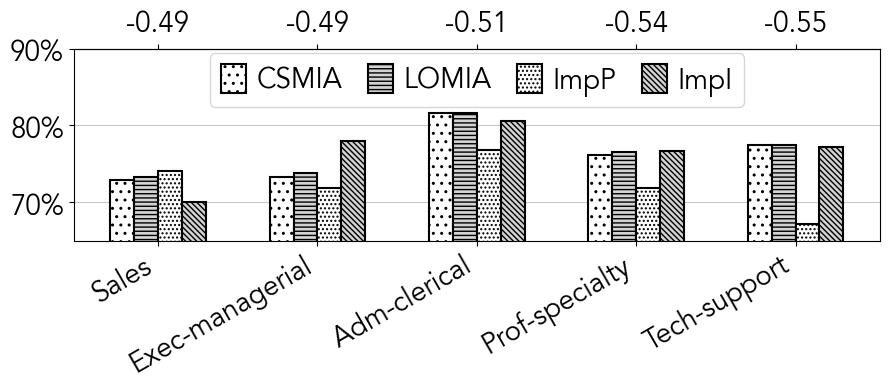

In [24]:
temp_df = perf_df.sort_values(by='correlation_diff')[['subgroup_val', 'correlation', 'CSMIA_attack_accuracy', 'LOMIA_attack_accuracy', 'imputation_accuracy', 'imputation_accuracy_ideal']]
temp_df = temp_df[temp_df['correlation'] < -0.45]
temp_df.index = temp_df['subgroup_val'].to_numpy()
temp_df = temp_df.drop(['subgroup_val'], axis=1)
temp_df = temp_df.drop(['Armed-Forces'], axis=0)

df = temp_df.copy()

hatches = ['0..', '----', '....', '\\\\\\\\\\\\', '--..', '//////', 'o', 'O', '.', '*']
alphas = [0.1, 0.9] * 4
fontsize = 20
colors = ['#FFFFFF', '#D3D3D3']

# Plotting
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Avenir'
fig, ax = plt.subplots(figsize=(9, 4))
plt.grid(True, linewidth=0.5, axis='y', zorder=0)

n_bars = len(df)

bar_width = 0.15

bar_positions = np.arange(n_bars)

ax.bar(bar_positions - 3 * bar_width / 2, 100 * df['CSMIA_attack_accuracy'], width=bar_width, label='CSMIA', hatch=hatches[0], color=colors[0], edgecolor='black', linewidth=1.5, zorder=2)

ax.bar(bar_positions - bar_width/2, 100 * df['LOMIA_attack_accuracy'], width=bar_width, label='LOMIA', hatch=hatches[1], color=colors[1], edgecolor='black', linewidth=1.5, zorder=2)

ax.bar(bar_positions + bar_width/2, 100 * df['imputation_accuracy'], width=bar_width, label='ImpP', hatch=hatches[2], color=colors[0], edgecolor='black', linewidth=1.5, zorder=2)

ax.bar(bar_positions + 3* bar_width / 2, 100 * df['imputation_accuracy_ideal'], width=bar_width, label='ImpI', hatch=hatches[3], color=colors[1], edgecolor='black', linewidth=1.5, zorder=2)

ax.set_ylim(65, 90)
ax.set_xticks(bar_positions)
ax.set_xticklabels(df.index, fontsize=fontsize, rotation=30, ha='right')

ax.set_yticks(np.arange(70, 100, 10))
ax.set_yticklabels([f'{i:.0f}%' for i in np.arange(70, 100, 10)], fontsize=fontsize)

secax = ax.secondary_xaxis('top')

secax.set_xticks(bar_positions)
secax.set_xticklabels([f'{correlation:.2f}' for correlation in df['correlation']], fontsize=fontsize)

plt.legend(bbox_to_anchor=(0.5, 1.05), loc='upper center', ncol=len(df.columns), fontsize=fontsize, prop={'size': fontsize}, handlelength=0.9, handleheight=1.2, columnspacing=0.9, handletextpad=0.4)

plt.tight_layout()
plt.show()